In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)

In [2]:
import optuna
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def objective(trial):

    alpha = trial.suggest_float('alpha', 0.01, 1.0)
    l1_ratio = trial.suggest_float('l1_ratio', 0.01, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')

improvement_threshold = 0.001
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 11000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Najlepsze parametry:", best_params)
print("Najlepszy R^2 Score:", best_r2)


[I 2023-11-10 19:57:07,270] A new study created in memory with name: no-name-7c37b7b9-ac50-4112-bc37-62ca45d846b2
[I 2023-11-10 19:57:07,277] Trial 0 finished with value: -0.7284219444891169 and parameters: {'alpha': 0.2620917645334085, 'l1_ratio': 0.31186574083298857}. Best is trial 0 with value: -0.7284219444891169.
[I 2023-11-10 19:57:07,281] Trial 1 finished with value: -0.6712139004219568 and parameters: {'alpha': 0.6522877008103236, 'l1_ratio': 0.3433375980633577}. Best is trial 1 with value: -0.6712139004219568.
[I 2023-11-10 19:57:07,287] Trial 2 finished with value: -0.6389513970940313 and parameters: {'alpha': 0.9459114875015604, 'l1_ratio': 0.08937958085828902}. Best is trial 2 with value: -0.6389513970940313.
[I 2023-11-10 19:57:07,292] Trial 3 finished with value: -0.7489478605637023 and parameters: {'alpha': 0.41011859251273297, 'l1_ratio': 0.8214664427549097}. Best is trial 2 with value: -0.6389513970940313.
[I 2023-11-10 19:57:07,297] Trial 4 finished with value: -0.786

Najlepsze parametry: {'alpha': 0.9999990715529352, 'l1_ratio': 0.010042665721235744}
Najlepszy R^2 Score: -0.6345930533321367


Średni błąd kwadratowy (MSE): 265.7531136039395
Procentowa zgodność: -63.46%


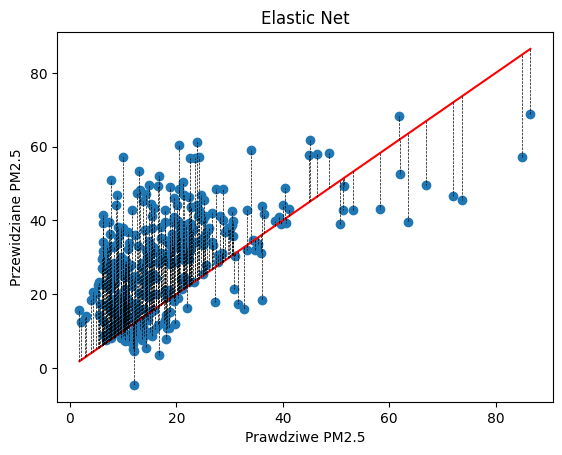

,Rzeczywiste wartości (y_test),Przewidywane wartości (y_pred),Różnica
0,10.46,19.253321,-8.793321
1,10.38,21.428020,-11.048020
2,10.29,24.516261,-14.226261
3,6.89,27.000989,-20.110989
4,7.56,26.222948,-18.662948
...,...,...,...
344,9.90,19.755410,-9.855410
345,8.40,10.676131,-2.276131
346,10.20,11.666694,-1.466694
347,8.40,14.612592,-6.212592


In [4]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


params =  {'alpha': 0.9999990715529352, 'l1_ratio': 0.010042665721235744}
model = ElasticNet(**params,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Elastic Net")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)']
results
